# Making infection chains from Delineo Simulator Data

In [ ]:
# Generate clean infection chain analysis for simulation data

import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
from collections import defaultdict, deque
from matplotlib.colors import LinearSegmentedColormap


# Read the CSV file
df = pd.read_csv("../data/raw/sample_2/infection_logs.csv")
print(f"Total infections: {len(df)}")

# Basic statistics
initial_infections = df['infector_person_id'].isna().sum()
print(f"Initial seed infections: {initial_infections}")
print(f"Secondary infections: {len(df) - initial_infections}")

# Create multiple visualizations for better understanding



Total infections: 381
Initial seed infections: 2
Secondary infections: 379


In [2]:
# 1. INFECTION GENERATION ANALYSIS
print("\n=== GENERATION ANALYSIS ===")
G = nx.DiGraph()

# Build the graph
for _, row in df.iterrows():
    infector = row['infector_person_id']
    infected = row['infected_person_id']
    
    if pd.isna(infector):
        infector = 'SEED'
    
    G.add_edge(infector, infected)

# Calculate generations using BFS
from collections import deque

generations = {}
queue = deque([('SEED', 0)])
generations['SEED'] = 0

while queue:
    node, gen = queue.popleft()
    for successor in G.successors(node):
        if successor not in generations:
            generations[successor] = gen + 1
            queue.append((successor, gen + 1))

print(f"Sample generations: {dict(list(generations.items())[:10])}")

# Debug: Check if we have any nodes
print(f"Total nodes in graph: {G.number_of_nodes()}")
print(f"Total edges in graph: {G.number_of_edges()}")
print(f"Nodes connected to SEED: {list(G.successors('SEED'))[:5]}")

# Count by generation
gen_counts = defaultdict(int)
for person, gen in generations.items():
    if person != 'SEED':
        gen_counts[gen] += 1

print(f"Generation counts: {dict(gen_counts)}")

print("Infections by generation:")
for gen in sorted(gen_counts.keys()):
    print(f"Generation {gen}: {gen_counts[gen]} people")


=== GENERATION ANALYSIS ===
Sample generations: {'SEED': 0, 3: 1, 4: 1, 27: 2, 36: 2, 47: 2, 12: 2, 44: 2, 15: 2, 67: 2}
Total nodes in graph: 125
Total edges in graph: 361
Nodes connected to SEED: [3, 4]
Generation counts: {1: 2, 2: 13, 3: 23, 4: 20, 5: 2, 6: 1}
Infections by generation:
Generation 1: 2 people
Generation 2: 13 people
Generation 3: 23 people
Generation 4: 20 people
Generation 5: 2 people
Generation 6: 1 people


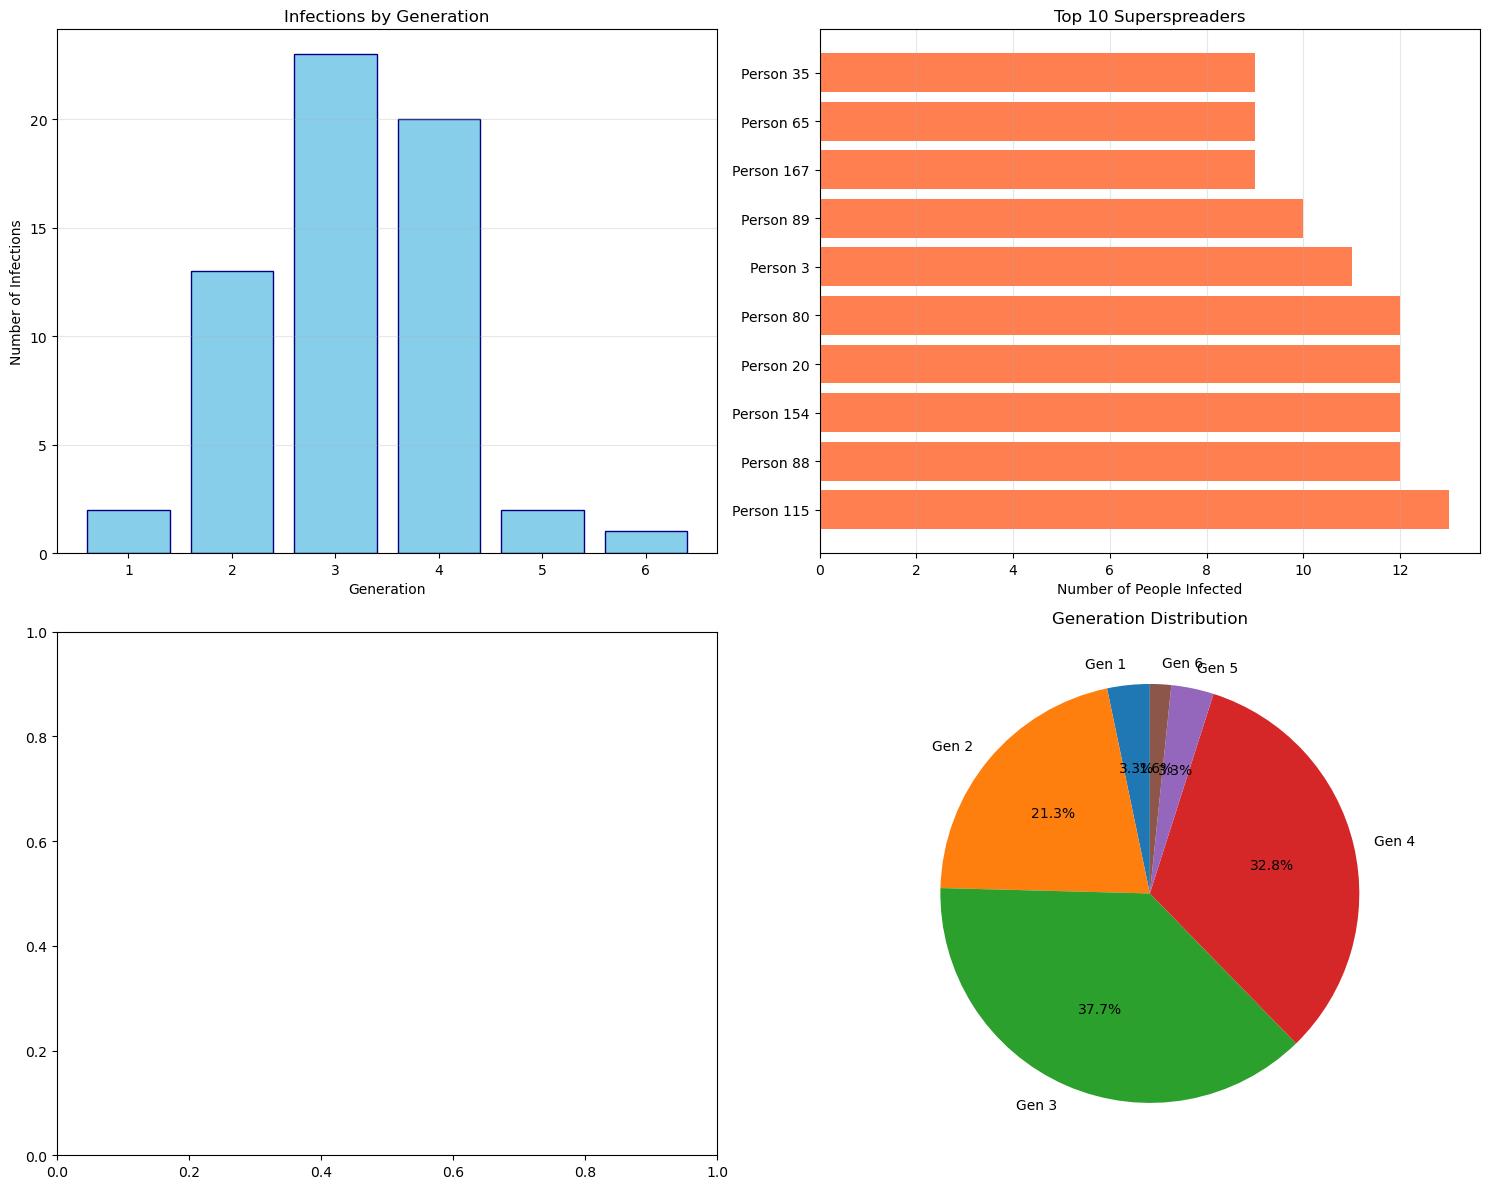

In [11]:
# 2. VISUALIZATION: Generation bar chart
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Generation distribution
if len(gen_counts) > 0:
    gens = list(gen_counts.keys())
    counts = [gen_counts.get(g, 0) for g in gens]
    ax1.bar(gens, counts, color='skyblue', edgecolor='navy')
    ax1.set_xlabel('Generation')
    ax1.set_ylabel('Number of Infections')
    ax1.set_title('Infections by Generation')
    ax1.grid(axis='y', alpha=0.3)
else:
    ax1.text(0.5, 0.5, 'No generation data found\nCheck your data structure', 
             transform=ax1.transAxes, ha='center', va='center')
    ax1.set_title('Infections by Generation - No Data')

# 3. Top superspreaders
infector_counts = df.groupby('infector_person_id').size().sort_values(ascending=False)
infector_counts = infector_counts.dropna()  # Remove NaN (initial seeds)

if len(infector_counts) > 0:
    top_spreaders = infector_counts.head(10)
    ax2.barh(range(len(top_spreaders)), top_spreaders.values, color='coral')
    ax2.set_yticks(range(len(top_spreaders)))
    ax2.set_yticklabels([f'Person {int(id)}' for id in top_spreaders.index])
    ax2.set_xlabel('Number of People Infected')
    ax2.set_title('Top 10 Superspreaders')
    ax2.grid(axis='x', alpha=0.3)


# 4. Infection timeline (if timestamp available)
if 'timestamp' in df.columns:
    time_col = 'timestamp'
    daily_infections = df.groupby(time_col).size()
    ax4.plot(daily_infections.index, daily_infections.values, marker='o', linewidth=2, markersize=4)
    ax4.set_xlabel('Time')
    ax4.set_ylabel('New Infections')
    ax4.set_title('Infection Timeline')
    ax4.grid(alpha=0.3)
else:
    # Show distribution of generation sizes as pie chart
    ax4.pie(counts, labels=[f'Gen {g}' for g in gens], autopct='%1.1f%%', startangle=90)
    ax4.set_title('Generation Distribution')

plt.tight_layout()
plt.show()

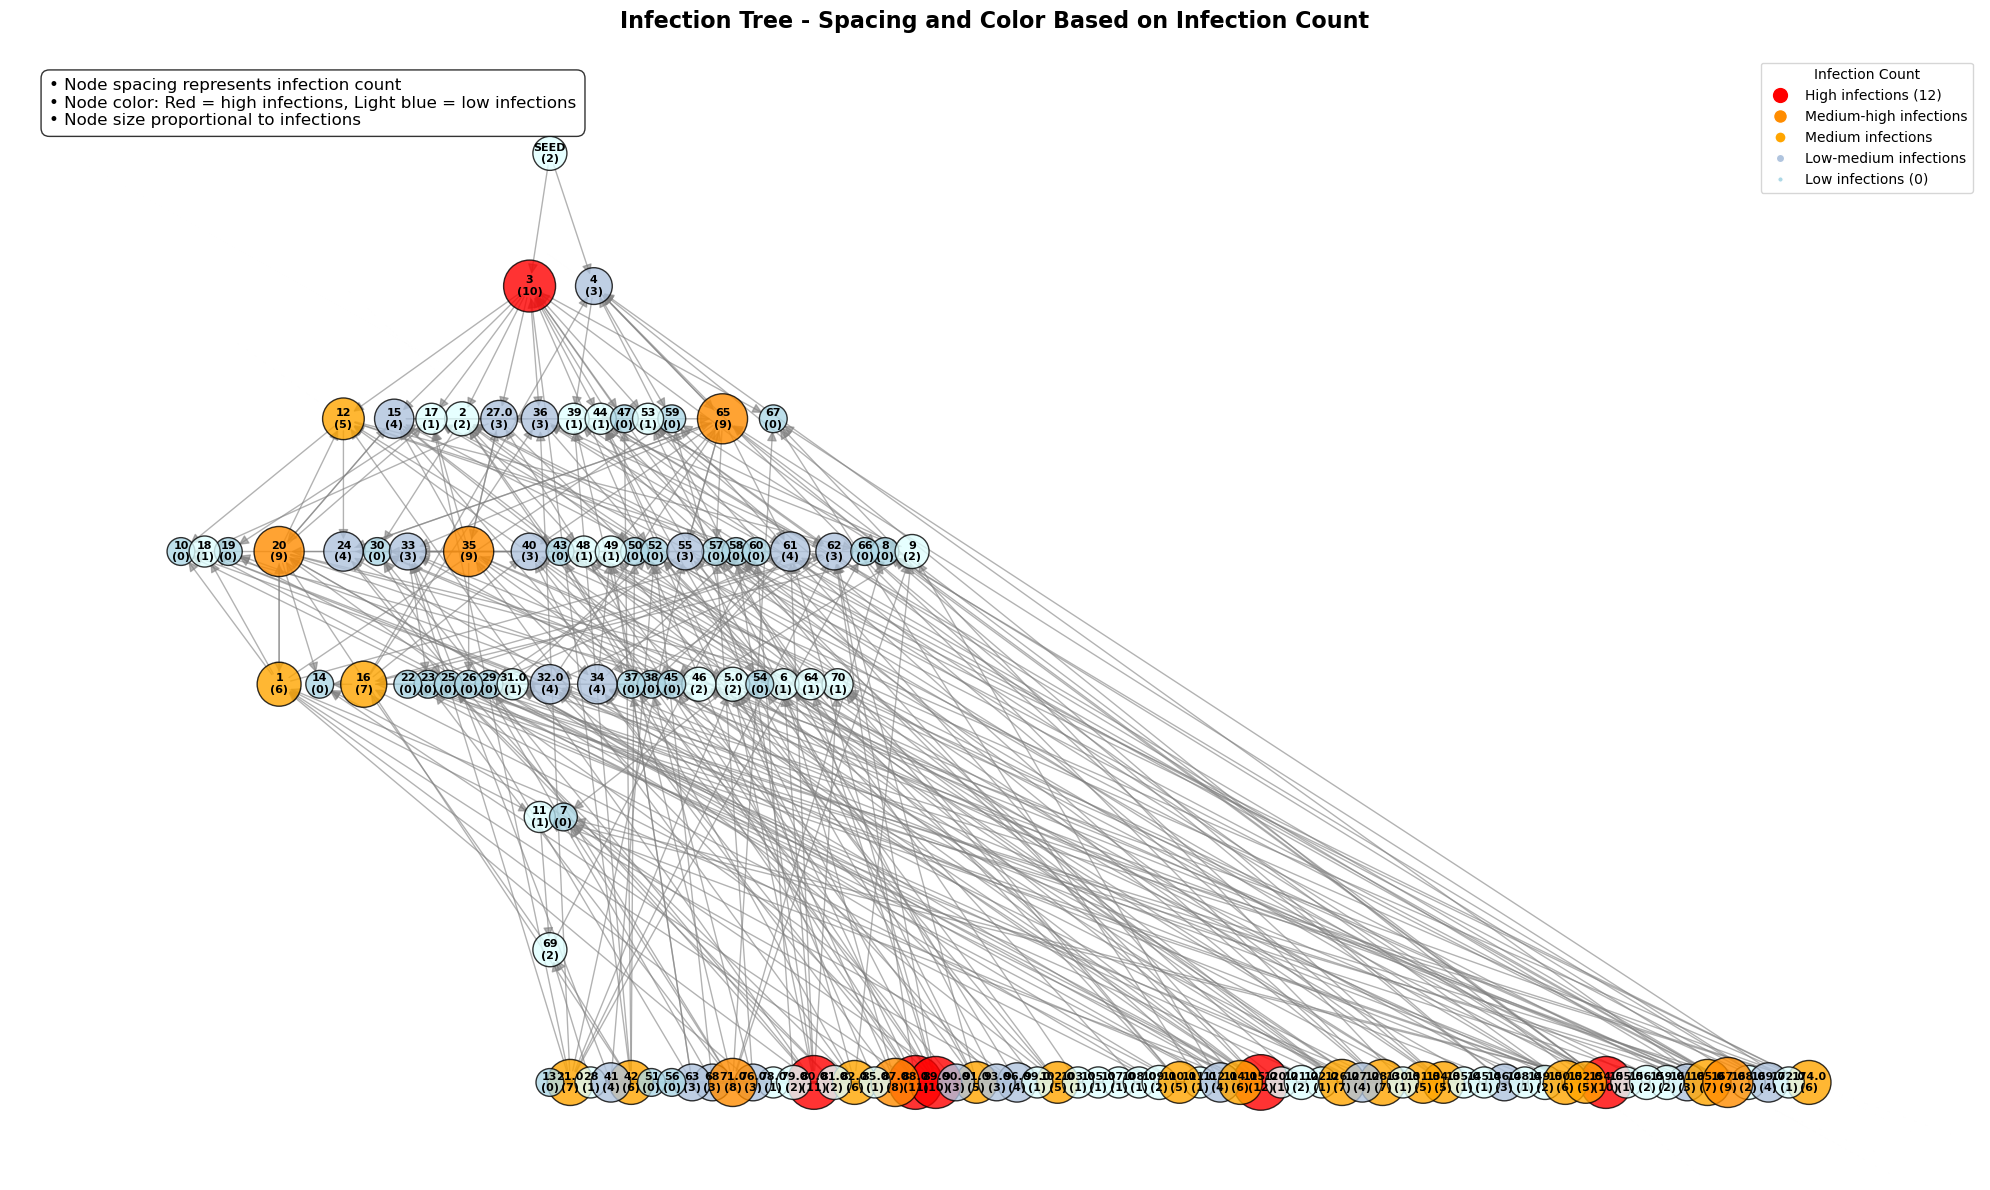

Infection Statistics:
Max infections by single node: 12
Total nodes: 125
Nodes with infections: 97


In [14]:
def create_infection_weighted_layout(G, root='SEED', base_spacing=2.0, infection_multiplier=0.5):
    """
    Generate a tree layout where spacing is proportional to infection count.
    
    Parameters:
    - G: NetworkX DiGraph
    - root: Root node (default 'SEED')
    - base_spacing: Minimum spacing between nodes
    - infection_multiplier: How much to scale spacing based on infection count
    """
    # Build generations
    generations = {}
    queue = deque([(root, 0)])
    generations[root] = 0

    while queue:
        node, gen = queue.popleft()
        for child in G.successors(node):
            if child not in generations:
                generations[child] = gen + 1
                queue.append((child, gen + 1))

    # Group by level
    level_nodes = defaultdict(list)
    for node, gen in generations.items():
        level_nodes[gen].append(node)

    # Calculate infection counts (out-degree)
    infection_counts = {}
    for node in G.nodes():
        infection_counts[node] = G.out_degree(node)

    # Compute positions with infection-weighted spacing
    pos = {}
    max_gen = max(generations.values()) if generations else 0

    for gen in range(max_gen + 1):
        nodes = sorted(level_nodes[gen], key=lambda x: str(x))
        
        if len(nodes) == 1:
            # Single node - center it
            pos[nodes[0]] = (0, -gen * 2)
            continue

        # Calculate spacing based on infection counts
        node_spacings = []
        for node in nodes:
            infection_count = infection_counts[node]
            # Base spacing + additional spacing based on infections
            spacing = base_spacing + (infection_count * infection_multiplier)
            node_spacings.append(spacing)

        # Calculate positions to center the level
        total_width = sum(node_spacings)
        start_x = -total_width / 2

        current_x = start_x
        for i, node in enumerate(nodes):
            if i == 0:
                # First node
                pos[node] = (current_x + node_spacings[i]/2, -gen * 2)
                current_x += node_spacings[i]
            else:
                # Subsequent nodes
                current_x += node_spacings[i]/2
                pos[node] = (current_x, -gen * 2)
                current_x += node_spacings[i]/2

    # Handle disconnected nodes
    all_nodes = set(G.nodes())
    missing = all_nodes - set(pos.keys())
    if missing:
        y = -(max_gen + 1) * 2
        for i, node in enumerate(sorted(missing)):
            pos[node] = (i * base_spacing, y)

    return pos, infection_counts

def get_infection_color(infection_count, max_infections):
    """
    Get color based on infection count - red for high, light blue for low.
    """
    if max_infections == 0:
        return 'lightblue'
    
    # Normalize infection count to 0-1 range
    normalized = infection_count / max_infections
    
    # Create color map from light blue (low) to red (high)
    if normalized == 0:
        return 'lightblue'
    elif normalized < 0.2:
        return 'lightcyan'
    elif normalized < 0.4:
        return 'lightsteelblue'
    elif normalized < 0.6:
        return 'orange'
    elif normalized < 0.8:
        return 'darkorange'
    else:
        return 'red'

# Create the visualization
def plot_infection_weighted_graph(G, base_spacing=3.0, infection_multiplier=1.0):
    """
    Plot the infection graph with weighted spacing and color coding.
    """
    # Create layout
    pos, infection_counts = create_infection_weighted_layout(G, 'SEED', base_spacing, infection_multiplier)
    
    # Get max infections for color scaling
    max_infections = max(infection_counts.values()) if infection_counts else 1
    
    # Create figure
    plt.figure(figsize=(20, 12))
    
    # Prepare node colors and sizes
    node_colors = []
    node_sizes = []
    
    for node in G.nodes():
        infection_count = infection_counts[node]
        
        # Color based on infection count
        color = get_infection_color(infection_count, max_infections)
        node_colors.append(color)
        
        # Size based on infection count
        base_size = 400
        size = base_size + (infection_count * 100)
        node_sizes.append(size)
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, 
                           node_color=node_colors,
                           node_size=node_sizes,
                           alpha=0.8,
                           edgecolors='black',
                           linewidths=1)
    
    # Draw edges
    nx.draw_networkx_edges(G, pos,
                           edge_color='gray',
                           arrows=True,
                           arrowsize=15,
                           alpha=0.6,
                           width=1)
    
    # Create labels with infection counts
    labels = {}
    for node in G.nodes():
        infection_count = infection_counts[node]
        if node == 'SEED':
            labels[node] = f"SEED\n({infection_count})"
        else:
            labels[node] = f"{node}\n({infection_count})"
    
    # Draw labels
    nx.draw_networkx_labels(G, pos,
                            labels=labels,
                            font_size=8,
                            font_weight='bold',
                            font_color='black')
    
    # Title
    plt.title("Infection Tree - Spacing and Color Based on Infection Count", 
              fontsize=16, fontweight='bold', pad=20)
    
    # Create custom legend for colors
    legend_elements = []
    
    # Color legend
    if max_infections > 0:
        legend_elements.extend([
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', 
                       markersize=12, label=f'High infections ({max_infections})'),
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='darkorange', 
                       markersize=10, label=f'Medium-high infections'),
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', 
                       markersize=8, label=f'Medium infections'),
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='lightsteelblue', 
                       markersize=6, label=f'Low-medium infections'),
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='lightblue', 
                       markersize=4, label=f'Low infections (0)')
        ])
    
    plt.legend(handles=legend_elements, loc='upper right', title='Infection Count')
    
    # Add explanation text
    plt.text(0.02, 0.98, 
             "• Node spacing represents infection count\n• Node color: Red = high infections, Light blue = low infections\n• Node size proportional to infections", 
             transform=plt.gca().transAxes, fontsize=12, 
             verticalalignment='top',
             bbox=dict(boxstyle="round,pad=0.5", facecolor="white", alpha=0.8))
    
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    # Print infection statistics
    print(f"Infection Statistics:")
    print(f"Max infections by single node: {max_infections}")
    print(f"Total nodes: {len(G.nodes())}")
    print(f"Nodes with infections: {sum(1 for count in infection_counts.values() if count > 0)}")


plot_infection_weighted_graph(G, base_spacing=3.0, infection_multiplier=1.0)


In [7]:
print(f"\n=== SUMMARY ===")
print(f"Total people infected: {len(df)}")
print(f"Initial seeds: {initial_infections}")
print(f"Maximum generation reached: {max(gen_counts.keys()) if gen_counts else 0}")
if len(infector_counts) > 0:
    print(f"Biggest superspreader infected: {infector_counts.iloc[0]} people")
    print(f"Average infections per spreader: {infector_counts.mean():.1f}")


=== SUMMARY ===
Total people infected: 381
Initial seeds: 2
Maximum generation reached: 6
Biggest superspreader infected: 13 people
Average infections per spreader: 3.9
